In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
import splitfolders
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary
import torch.nn.init as init

In [2]:
PATH = 'C:\\Users\\Chiki\\jupyter\\masters_course\\data\\cataract\\processed_images\\'

In [ ]:
splitfolders.ratio(PATH + 'train', PATH + 'train', seed=42, ratio=(0.8, 0.2))

In [3]:
TRAIN_PATH = PATH + 'train\\train'
VAL_PATH = PATH + 'train\\val'
TEST_PATH = PATH + 'test'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root = TRAIN_PATH, transform=transform)
val_dataset = datasets.ImageFolder(root = VAL_PATH, transform=transform)
test_dataset = datasets.ImageFolder(root=TEST_PATH, transform=transform)

In [4]:
batch_size = 10

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
classes = train_dataset.classes
num_classes = len(classes)

print(f'Classes: {classes}')
print(f'Num_classes: {num_classes}')

Classes: ['cataract', 'normal']
Num_classes: 2


In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # 1 convolution block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2 convolution block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3 convolution block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 4 convolution block
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same')
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')  # He initialization для Conv2d
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)
                init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.act4(x)
        x = self.pool4(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [8]:
class ModelCompilation():
  def __init__(self,
               model,
               loss_function,
               optimizer,
               device):
    self.model = model.to(device)      
    self.loss_function = loss_function
    self.optimizer = optimizer         
    self.device = device              

    # Metrics for calculating accuracy during training, validation and testing
    self.train_accuracy = torchmetrics.Accuracy(task='binary', num_classes=2).to(device)
    self.val_accuracy = torchmetrics.Accuracy(task='binary', num_classes=2).to(device)
    self.test_accuracy = torchmetrics.Accuracy(task='binary', num_classes=2).to(device)

    # Initialize best validation error to infinity so improvements can be tracked
    self.best_val_loss = float('inf') 

    # Dictionary for storing metrics across all eras
    self.history = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }

   # List for storing the model's predictions on the test
    self.mlp_preds = []

  # Training step on one epoch
  def train_step(self, dataloader):
      self.model.train()            
      running_loss = 0.0           
      self.train_accuracy.reset()  

      
      for X_batch, y_batch in dataloader:
          X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device) 

          self.optimizer.zero_grad()                       

          y_pred = self.model(X_batch).squeeze()           

          loss = self.loss_function(y_pred, y_batch.float()) 
          running_loss += loss.item() * X_batch.size(0)     # увеличиваем сумму ошибок, умножая на количество примеров (чтобы получить общую потерю на всех примерах)

          loss.backward()                                 
          self.optimizer.step()                         

          self.train_accuracy.update(y_pred, y_batch.int())

      # Average final error and accuracy per training epoch
      train_loss = running_loss / len(dataloader.dataset)
      train_accuracy = self.train_accuracy.compute()

      return train_loss, train_accuracy

  
  def val_step(self, dataloader):
      self.model.eval()         
      running_loss = 0.0        
      self.val_accuracy.reset() 

      
      with torch.no_grad():
          for X_batch, y_batch in dataloader:
              X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

              y_pred = self.model(X_batch).squeeze()            

              loss = self.loss_function(y_pred, y_batch.float()) 
              running_loss += loss.item() * X_batch.size(0)      # увеличение суммы ошибки, умножая на количество примеров (чтобы получить общую потерю на всех примерах)

              self.val_accuracy.update(y_pred, y_batch.int())  

      # Average final error and accuracy for the entire validation
      val_loss = running_loss / len(dataloader.dataset)
      val_accuracy = self.val_accuracy.compute()

      return val_loss, val_accuracy

    
  def test_step(self, dataloader):
      self.model.eval()         
      running_loss = 0.0         
      self.test_accuracy.reset() 

      with torch.no_grad():
          for X_batch, y_batch in dataloader:
              X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device) 
              
              y_pred = self.model(X_batch).squeeze()                          
              self.mlp_preds.append(np.argmax(y_pred.cpu()).numpy())   

              if y_pred.dim() == 0:  
                  y_pred = y_pred.unsqueeze(0) 
              
              loss = self.loss_function(y_pred, y_batch.float())      
              running_loss += loss.item() * X_batch.size(0)          # увеличение суммы ошибки, умножая на количество примеров (чтобы получить общую потерю на всех примерах)

              self.test_accuracy.update(y_pred, y_batch.int()) 

      test_loss = running_loss / len(dataloader.dataset)
      test_accuracy = self.test_accuracy.compute()

      if y_pred.numel() != 1:  
          self.mlp_preds = np.concatenate(self.mlp_preds) 

      return test_loss, test_accuracy

    
  def fit(self, train_dataloader, val_dataloader, epochs=20):
      self.best_val_loss = float('inf')
      for epoch in tqdm(range(epochs)):
          train_loss, train_accuracy = self.train_step(train_dataloader)
          val_loss, val_accuracy = self.val_step(val_dataloader)

          # Print the results of the current era
          print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} - train_accuracy: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}')

          # Save the best model
          # If the current validation error is less than the previous one
          if val_loss < self.best_val_loss:
              print(f"Validation loss improved from {self.best_val_loss:.4f} to {val_loss:.4f}. Saving weights... \n")
              self.best_val_loss = val_loss # update the value of the best validation error
              torch.save(self.model.state_dict(), 'best_model.pth')
          else:
              print(f"No improvement in validation loss. Best validation loss remains: {self.best_val_loss:.4f} \n")

          # Save the metrics calculated in a given epoch to a dictionary
          self.history["train_loss"].append(train_loss)
          self.history["train_accuracy"].append(train_accuracy.item())
          self.history["val_loss"].append(val_loss)
          self.history["val_accuracy"].append(val_accuracy.item())

      return self.model # return the trained model

  def testing(self, test_loader, checkpoint_path):
      # Load the best saved model
      self.model.load_state_dict(torch.load(checkpoint_path))

      test_loss, test_accuracy = self.test_step(test_loader)
      print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

  def plot_metrics(self):
        epochs_range = range(1, len(self.history["train_loss"]) + 1)

        # Plotting graphs
        plt.figure(figsize=(12, 5))

        # Plotting the error graph
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, self.history["train_loss"], label="Train Loss")
        plt.plot(epochs_range, self.history["val_loss"], label="Validation Loss")
        plt.title("График изменения ошибки модели")
        plt.xlabel("Эпохи")
        plt.ylabel("Ошибка")
        plt.legend()

        # Plotting the accuracy graph
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, self.history["train_accuracy"], label="Train Accuracy")
        plt.plot(epochs_range, self.history["val_accuracy"], label="Validation Accuracy")
        plt.title("График изменения точности модели")
        plt.xlabel("Эпохи")
        plt.ylabel("Точность")
        plt.legend()
        plt.show()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

model = ConvNet() 
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_compilation = ModelCompilation(model=model, loss_function=loss_function, optimizer=optimizer, device=device) 

In [10]:
summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
             ReLU-11          [-1, 256, 28, 28]               0
        MaxPool2d-12          [-1, 256, 14, 14]               0
AdaptiveAvgPool2d-13            [-1, 256, 1, 1]               0
           Linear-14                   

In [11]:
# Training the model
model = model_compilation.fit(train_dataloader=train_dataloader,
                              val_dataloader=val_dataloader,     
                              epochs=37)    

  3%|██▏                                                                                | 1/37 [00:57<34:36, 57.68s/it]

Epoch 1: train_loss: 0.7016 - train_accuracy: 0.5102 - val_loss: 0.6936 - val_accuracy: 0.4949
Validation loss improved from inf to 0.6936. Saving weights... 



  5%|████▍                                                                              | 2/37 [01:56<34:10, 58.59s/it]

Epoch 2: train_loss: 0.6946 - train_accuracy: 0.5000 - val_loss: 0.6904 - val_accuracy: 0.4949
Validation loss improved from 0.6936 to 0.6904. Saving weights... 



  8%|██████▋                                                                            | 3/37 [02:54<32:51, 57.99s/it]

Epoch 3: train_loss: 0.6886 - train_accuracy: 0.5179 - val_loss: 0.6874 - val_accuracy: 0.4646
Validation loss improved from 0.6904 to 0.6874. Saving weights... 



 11%|████████▉                                                                          | 4/37 [03:52<31:53, 57.97s/it]

Epoch 4: train_loss: 0.6906 - train_accuracy: 0.4847 - val_loss: 0.6860 - val_accuracy: 0.4848
Validation loss improved from 0.6874 to 0.6860. Saving weights... 



 14%|███████████▏                                                                       | 5/37 [04:52<31:22, 58.84s/it]

Epoch 5: train_loss: 0.6836 - train_accuracy: 0.4566 - val_loss: 0.6838 - val_accuracy: 0.4646
Validation loss improved from 0.6860 to 0.6838. Saving weights... 



 16%|█████████████▍                                                                     | 6/37 [05:54<31:02, 60.08s/it]

Epoch 6: train_loss: 0.6816 - train_accuracy: 0.5128 - val_loss: 0.6759 - val_accuracy: 0.4747
Validation loss improved from 0.6838 to 0.6759. Saving weights... 



 19%|███████████████▋                                                                   | 7/37 [06:57<30:30, 61.02s/it]

Epoch 7: train_loss: 0.6784 - train_accuracy: 0.5128 - val_loss: 0.6632 - val_accuracy: 0.5556
Validation loss improved from 0.6759 to 0.6632. Saving weights... 



 22%|█████████████████▉                                                                 | 8/37 [07:59<29:33, 61.14s/it]

Epoch 8: train_loss: 0.6791 - train_accuracy: 0.5434 - val_loss: 0.6722 - val_accuracy: 0.5657
No improvement in validation loss. Best validation loss remains: 0.6632 



 24%|████████████████████▏                                                              | 9/37 [08:56<27:58, 59.95s/it]

Epoch 9: train_loss: 0.6688 - train_accuracy: 0.5612 - val_loss: 0.6514 - val_accuracy: 0.5556
Validation loss improved from 0.6632 to 0.6514. Saving weights... 



 27%|██████████████████████▏                                                           | 10/37 [09:50<26:06, 58.02s/it]

Epoch 10: train_loss: 0.6766 - train_accuracy: 0.5612 - val_loss: 0.6644 - val_accuracy: 0.5556
No improvement in validation loss. Best validation loss remains: 0.6514 



 30%|████████████████████████▍                                                         | 11/37 [10:44<24:35, 56.74s/it]

Epoch 11: train_loss: 0.6566 - train_accuracy: 0.5791 - val_loss: 0.6214 - val_accuracy: 0.6970
Validation loss improved from 0.6514 to 0.6214. Saving weights... 



 32%|██████████████████████████▌                                                       | 12/37 [11:39<23:30, 56.41s/it]

Epoch 12: train_loss: 0.6291 - train_accuracy: 0.6556 - val_loss: 0.5810 - val_accuracy: 0.7172
Validation loss improved from 0.6214 to 0.5810. Saving weights... 



 35%|████████████████████████████▊                                                     | 13/37 [12:33<22:13, 55.56s/it]

Epoch 13: train_loss: 0.6175 - train_accuracy: 0.6250 - val_loss: 0.5935 - val_accuracy: 0.7576
No improvement in validation loss. Best validation loss remains: 0.5810 



 38%|███████████████████████████████                                                   | 14/37 [13:27<21:05, 55.04s/it]

Epoch 14: train_loss: 0.5854 - train_accuracy: 0.7143 - val_loss: 0.5580 - val_accuracy: 0.6970
Validation loss improved from 0.5810 to 0.5580. Saving weights... 



 41%|█████████████████████████████████▏                                                | 15/37 [14:20<19:56, 54.39s/it]

Epoch 15: train_loss: 0.6086 - train_accuracy: 0.6684 - val_loss: 0.5873 - val_accuracy: 0.7273
No improvement in validation loss. Best validation loss remains: 0.5580 



 43%|███████████████████████████████████▍                                              | 16/37 [15:14<19:00, 54.31s/it]

Epoch 16: train_loss: 0.5613 - train_accuracy: 0.7143 - val_loss: 0.5148 - val_accuracy: 0.8081
Validation loss improved from 0.5580 to 0.5148. Saving weights... 



 46%|█████████████████████████████████████▋                                            | 17/37 [16:07<18:00, 54.04s/it]

Epoch 17: train_loss: 0.5150 - train_accuracy: 0.7730 - val_loss: 0.4846 - val_accuracy: 0.8283
Validation loss improved from 0.5148 to 0.4846. Saving weights... 



 49%|███████████████████████████████████████▉                                          | 18/37 [17:02<17:12, 54.35s/it]

Epoch 18: train_loss: 0.4372 - train_accuracy: 0.8189 - val_loss: 0.4431 - val_accuracy: 0.8283
Validation loss improved from 0.4846 to 0.4431. Saving weights... 



 51%|██████████████████████████████████████████                                        | 19/37 [17:56<16:13, 54.08s/it]

Epoch 19: train_loss: 0.4210 - train_accuracy: 0.8087 - val_loss: 0.4438 - val_accuracy: 0.8384
No improvement in validation loss. Best validation loss remains: 0.4431 



 54%|████████████████████████████████████████████▎                                     | 20/37 [18:49<15:15, 53.85s/it]

Epoch 20: train_loss: 0.3644 - train_accuracy: 0.8367 - val_loss: 0.3949 - val_accuracy: 0.8081
Validation loss improved from 0.4431 to 0.3949. Saving weights... 



 57%|██████████████████████████████████████████████▌                                   | 21/37 [19:42<14:19, 53.72s/it]

Epoch 21: train_loss: 0.3665 - train_accuracy: 0.8418 - val_loss: 0.4496 - val_accuracy: 0.8485
No improvement in validation loss. Best validation loss remains: 0.3949 



 59%|████████████████████████████████████████████████▊                                 | 22/37 [20:35<13:20, 53.39s/it]

Epoch 22: train_loss: 0.3340 - train_accuracy: 0.8597 - val_loss: 0.3587 - val_accuracy: 0.8586
Validation loss improved from 0.3949 to 0.3587. Saving weights... 



 62%|██████████████████████████████████████████████████▉                               | 23/37 [21:29<12:29, 53.53s/it]

Epoch 23: train_loss: 0.2966 - train_accuracy: 0.8750 - val_loss: 0.3717 - val_accuracy: 0.8384
No improvement in validation loss. Best validation loss remains: 0.3587 



 65%|█████████████████████████████████████████████████████▏                            | 24/37 [22:22<11:35, 53.49s/it]

Epoch 24: train_loss: 0.3013 - train_accuracy: 0.8699 - val_loss: 0.3792 - val_accuracy: 0.8586
No improvement in validation loss. Best validation loss remains: 0.3587 



 68%|███████████████████████████████████████████████████████▍                          | 25/37 [23:16<10:43, 53.66s/it]

Epoch 25: train_loss: 0.2406 - train_accuracy: 0.9005 - val_loss: 0.3601 - val_accuracy: 0.8384
No improvement in validation loss. Best validation loss remains: 0.3587 



 70%|█████████████████████████████████████████████████████████▌                        | 26/37 [24:11<09:52, 53.85s/it]

Epoch 26: train_loss: 0.2537 - train_accuracy: 0.8852 - val_loss: 0.3058 - val_accuracy: 0.8788
Validation loss improved from 0.3587 to 0.3058. Saving weights... 



 73%|███████████████████████████████████████████████████████████▊                      | 27/37 [25:04<08:55, 53.56s/it]

Epoch 27: train_loss: 0.2123 - train_accuracy: 0.9107 - val_loss: 0.4719 - val_accuracy: 0.8485
No improvement in validation loss. Best validation loss remains: 0.3058 



 76%|██████████████████████████████████████████████████████████████                    | 28/37 [25:56<07:58, 53.20s/it]

Epoch 28: train_loss: 0.1911 - train_accuracy: 0.9209 - val_loss: 0.4332 - val_accuracy: 0.8889
No improvement in validation loss. Best validation loss remains: 0.3058 



 78%|████████████████████████████████████████████████████████████████▎                 | 29/37 [26:52<07:12, 54.00s/it]

Epoch 29: train_loss: 0.1528 - train_accuracy: 0.9413 - val_loss: 0.3750 - val_accuracy: 0.8586
No improvement in validation loss. Best validation loss remains: 0.3058 



 81%|██████████████████████████████████████████████████████████████████▍               | 30/37 [27:46<06:19, 54.20s/it]

Epoch 30: train_loss: 0.1869 - train_accuracy: 0.9286 - val_loss: 0.6171 - val_accuracy: 0.8283
No improvement in validation loss. Best validation loss remains: 0.3058 



 84%|████████████████████████████████████████████████████████████████████▋             | 31/37 [28:42<05:26, 54.49s/it]

Epoch 31: train_loss: 0.1806 - train_accuracy: 0.9209 - val_loss: 0.3352 - val_accuracy: 0.8586
No improvement in validation loss. Best validation loss remains: 0.3058 



 86%|██████████████████████████████████████████████████████████████████████▉           | 32/37 [29:36<04:31, 54.34s/it]

Epoch 32: train_loss: 0.1342 - train_accuracy: 0.9413 - val_loss: 0.4260 - val_accuracy: 0.8889
No improvement in validation loss. Best validation loss remains: 0.3058 



 89%|█████████████████████████████████████████████████████████████████████████▏        | 33/37 [30:29<03:35, 53.97s/it]

Epoch 33: train_loss: 0.1434 - train_accuracy: 0.9439 - val_loss: 0.3703 - val_accuracy: 0.8889
No improvement in validation loss. Best validation loss remains: 0.3058 



 92%|███████████████████████████████████████████████████████████████████████████▎      | 34/37 [31:23<02:42, 54.04s/it]

Epoch 34: train_loss: 0.1066 - train_accuracy: 0.9643 - val_loss: 0.3524 - val_accuracy: 0.8586
No improvement in validation loss. Best validation loss remains: 0.3058 



 95%|█████████████████████████████████████████████████████████████████████████████▌    | 35/37 [32:17<01:48, 54.18s/it]

Epoch 35: train_loss: 0.0971 - train_accuracy: 0.9592 - val_loss: 0.3736 - val_accuracy: 0.8586
No improvement in validation loss. Best validation loss remains: 0.3058 



 97%|███████████████████████████████████████████████████████████████████████████████▊  | 36/37 [33:12<00:54, 54.32s/it]

Epoch 36: train_loss: 0.1446 - train_accuracy: 0.9337 - val_loss: 0.4976 - val_accuracy: 0.8788
No improvement in validation loss. Best validation loss remains: 0.3058 



100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [34:06<00:00, 55.30s/it]

Epoch 37: train_loss: 0.1342 - train_accuracy: 0.9515 - val_loss: 0.4595 - val_accuracy: 0.8990
No improvement in validation loss. Best validation loss remains: 0.3058 



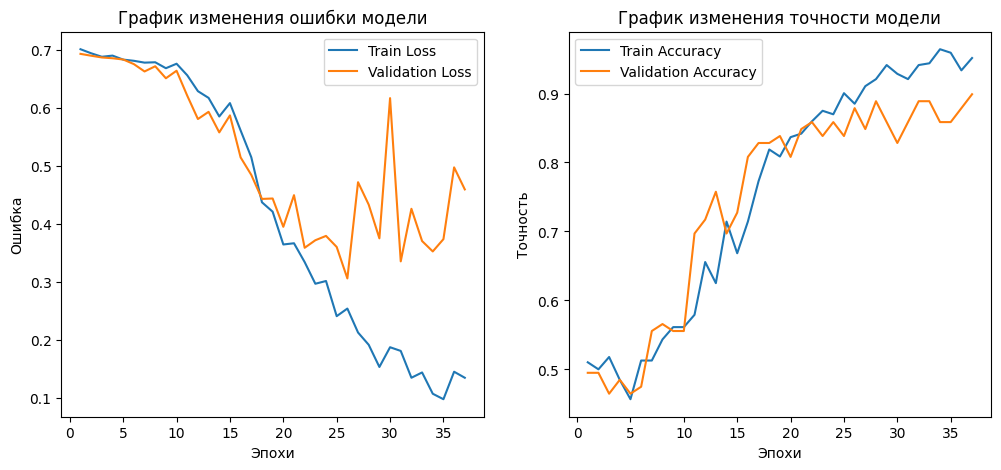

In [12]:
# Building training schedules
model_compilation.plot_metrics()

In [13]:
# Testing the best model (specify the path to the file with the best model)
model_compilation.testing(test_loader=test_dataloader, checkpoint_path='C:\\Users\\Chiki\\jupyter\\masters_course\\best_model.pth')

C:\Users\Chiki\AppData\Local\Temp\ipykernel_16364\4148115392.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(checkpoint_path))


Test Accuracy: 85.95%


Предсказанный класс: cataract
Правильный класс: cataract


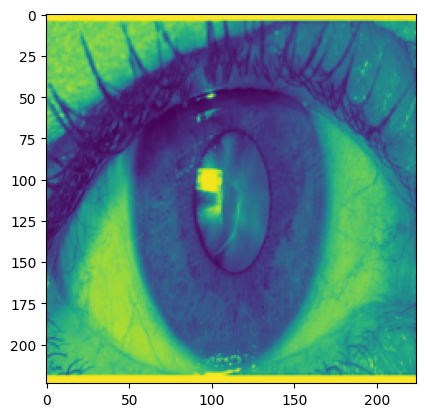

In [14]:
model.eval()

# Get one random batch of data
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# Select a random image index in the batch
random_index = np.random.randint(0, len(images) - 1)

# Get a random image and its class label
image = images[random_index]
label = labels[random_index]
image = image.unsqueeze(0).to(device)

# Predict class
with torch.no_grad():
    predictions = model(image)
    predicted_class_index = torch.argmax(predictions, dim=1).item()

# Print the predicted class and the correct class
print("Предсказанный класс:", classes[predicted_class_index])
print("Правильный класс:", classes[label.item()])

# Visualize the image
image_np = image.squeeze(0).cpu().numpy()     
image_np = np.transpose(image_np, (1, 2, 0))  # Change the axes for correct display

plt.imshow(image_np)
plt.show()